# 항공사 고객 만족도 예측 경진대회

## 패키지 import 및 데이터 전처리

In [637]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set_theme()

In [2]:
pd.set_option('display.max_columns', None) ## 컬럼 전체를 출력하도록 설정

In [502]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/항공사-고객만족도-예측/Data/train.csv')
test = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/항공사-고객만족도-예측/Data/test.csv')

In [83]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
0,1,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0.0,0
1,2,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,4,1,4,3,5,5,4,2,1,5,2,18,18.0,0
2,3,Male,Loyal Customer,46,Business travel,Business,2622,1,1,1,1,4,5,5,4,4,4,4,5,4,3,0,0.0,1
3,4,Female,disloyal Customer,24,Business travel,Eco,2348,3,3,3,3,3,3,3,3,2,4,5,3,4,3,10,2.0,0
4,5,Female,Loyal Customer,58,Business travel,Business,105,3,3,3,3,4,4,5,4,4,4,4,4,4,5,0,0.0,1


|컬럼명|세부사항|
|:-:|:-:|
|id | 샘플 아이디|
|Gender | 성별|
|Customer Type | Disloyal 또는 Loyal 고객|
|Age | 나이|
|Type of Travel | Business 또는 Personal Travel
|Class | 등급|
|Flight Distance | 비행 거리|
|Seat comfort | 좌석 만족도|
|Departure/Arrival time convenient | 출발/도착 시간 편의성 만족도|
|Food and drink | 식음료 만족도|
|Gate location | 게이트 위치 만족도|
|Inflight wifi service | 기내 와이파이 서비스 만족도|
|Inflight entertainment | 기내 엔터테인먼트 만족도|
|Online support |온라인 지원 만족도|
|Ease of Online booking| 온라인 예매 편리성 만족도|
|On-board service | 탑승 서비스 만족도|
|Leg room service | Leg room 서비스 만족도|
|Baggage handling | 수하물 처리 만족도|
|Checkin service | 체크인 서비스 만족도|
|Cleanliness | 청결도 만족도|
|Online boarding | 온라인보딩 만족도|
|Departure Delay in Minutes | 출발 지연 시간|
|Arrival Delay in Minutes | 도착 지연 시간|
|target | 만족 여부|

In [503]:
df.drop('id', axis = 1, inplace = True) ## id는 필요없으니 제거
test.drop('id', axis = 1, inplace = True) ## id는 필요없으니 제거

`-` 나이는 범주화 시키겠다

`-` 그런데 1\~10과 71\~80은 표본이 적은 관계로 다른 범주와 통합시키겠다

In [85]:
def categorize_age(age):
    for i in range(2, 8):  ## 10살 이하여도 11~20 범주에 포함 
        if age <= i*10:
            return i-1  
        
    return 6  ## 71살 이상이면 61~70 범주에 포함 

In [505]:
#df['Age'] = df['Age'].apply(lambda x: categorize_age(x)) 
df['Age'] = df['Age'].apply(lambda x: 0 if x <= 35 else 1) ## 35세 전후로 나눈다
test['Age'] = test['Age'].apply(lambda x: 0 if x <= 35 else 1) ## 35세 전후로 나눈다

In [309]:
df['Age'].value_counts()

1    1793
0    1207
Name: Age, dtype: int64

<AxesSubplot:xlabel='Age', ylabel='count'>

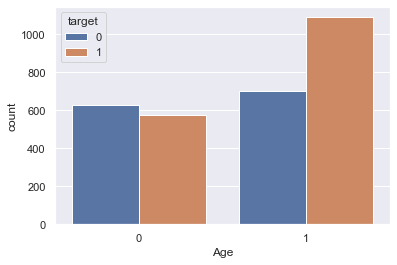

In [310]:
sns.countplot(x = 'Age', hue = 'target', data = df) 

`-` Eco plus는 Eco로 취급하자(등급이 비즈니스이냐 이코노미이냐가 중요함)

In [507]:
df['Class'] = df['Class'].apply(lambda x: 'Eco' if x == 'Eco Plus' else x)
test['Class'] = test['Class'].apply(lambda x: 'Eco' if x == 'Eco Plus' else x)

`-` EDA에서 확인바와 같이 비행거리도 범주화 시키겠다(킬로미터인지 마일인지는 모르겠음; 편의상 km라고 하자)

`-` 1000km를 기준으로 가까우면 0, 멀면 1로 맵핑하겠다

In [508]:
df['Flight Distance'] = df['Flight Distance'].apply(lambda x: 0 if x <= 1000 else 1)
test['Flight Distance'] = test['Flight Distance'].apply(lambda x: 0 if x <= 1000 else 1)

In [313]:
df['Flight Distance'].value_counts()

1    2484
0     516
Name: Flight Distance, dtype: int64

`-` 출발 시간 딜레이와 도착 시간 딜레이는 딜레이가 있으면 1, 없으면 0으로 코딩하겠다

In [513]:
df['Departure Delay in Minutes'] = df['Departure Delay in Minutes'].apply(lambda x: 1 if x > 0 else 0)
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].apply(lambda x: 1 if x > 0 else 0)

test['Departure Delay in Minutes'] = test['Departure Delay in Minutes'].apply(lambda x: 1 if x > 0 else 0)
test['Arrival Delay in Minutes'] = test['Arrival Delay in Minutes'].apply(lambda x: 1 if x > 0 else 0)

In [514]:
sum(df['Arrival Delay in Minutes'] == df['Departure Delay in Minutes'])

2378

`-` 출발 시간 딜레이가 있으면 대체로 도착 시간 딜레이도 있다

`-` 문자형 타입 변수를 수치형 타입으로 변환하자

`-` 범주가 많아야 2개이므로 라벨인코딩을 하자(0 또는 1, 2는 unknown)

In [515]:
## 코드 출처 : https://dacon.io/competitions/official/235871/codeshare/4420?page=1&dtype=recent
## 라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(df):
    label_maps = {} ## 문자타입 컬럼들을 맵핑해줄 딕셔러니 집합 생성
    for col in df.columns:
        if df[col].dtype == 'object':
            label_map = {'unknown':2} ## 빈 딕셔러니 생성
            for i, key in enumerate(df[col].unique()):
                label_map[key] = i  ## 새로 등장하는 유니크 값들에 대해 0부터 1씩 증가시켜 키값을 부여
                
            label_maps[col] = label_map  ## 하나의 컬럼에 대한 맵핑을 추가
            
    return label_maps

## 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(df_, label_map):
    df = df_.copy()
    
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].map(label_map[col]) ## 맵핑
            df[col] = df[col].fillna(label_map[col]['unknown']) ## 혹시 모를 결측값은 unknown의 값(2)으로 채움
            
    return df

In [516]:
## train 데이터 라벨 인코딩
label_map = make_label_map(df) ## train 사용해 label map 생성
df = label_encoder(df, label_map) ## train 라벨 인코딩

In [517]:
label_map

{'Gender': {'unknown': 2, 'Female': 0, 'Male': 1},
 'Customer Type': {'unknown': 2, 'disloyal Customer': 0, 'Loyal Customer': 1},
 'Type of Travel': {'unknown': 2, 'Business travel': 0, 'Personal Travel': 1},
 'Class': {'unknown': 2, 'Eco': 0, 'Business': 1}}

In [518]:
test = label_encoder(test, label_map) ## train 라벨 인코딩

In [321]:
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Avg_service,target
0,0,0,0,0,0,1,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0,3.571429,0
1,0,1,1,0,1,1,2,4,4,4,1,4,3,5,5,4,2,1,5,2,1,1,3.285714,0
2,1,1,1,0,1,1,1,1,1,1,4,5,5,4,4,4,4,5,4,3,0,0,3.285714,1
3,0,0,0,0,0,1,3,3,3,3,3,3,3,3,2,4,5,3,4,3,1,1,3.214286,0
4,0,1,1,0,1,0,3,3,3,3,4,4,5,4,4,4,4,4,4,5,0,0,3.857143,1


`-` 모두 범주형 변수이다!

## 간단한 모델링

In [638]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

In [110]:
def accuracy(true, pred):   
    score = np.mean(true == pred)
    return score

In [528]:
dt = df.copy()

In [529]:
target = dt['target']
dt.drop('target', axis = 1, inplace = True)

In [531]:
#dt.drop(['Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis = 1, inplace = True)
#dt.drop(['Avg_service'], axis = 1, inplace = True)

In [685]:
skfold = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 22)

### 로지스틱 회귀

In [418]:
logistic_reg = LogisticRegression(random_state = 22, max_iter = 500) 

In [419]:
scores = cross_validate(logistic_reg, dt, target, return_train_score = True, scoring = 'accuracy', cv = skfold)

In [420]:
np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.8467499999999999, 0.8383333333333333)

### 랜덤포레스트

In [421]:
rf = RandomForestClassifier(random_state = 22)

In [422]:
rf.fit(dt, target)

RandomForestClassifier(random_state=22)

In [423]:
_ = pd.DataFrame(dict(zip(rf.feature_names_in_, rf.feature_importances_)), index = [0]).T.\
reset_index().rename(columns = {'index':'feature', 0:'importance'}).\
sort_values('importance', ascending = False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

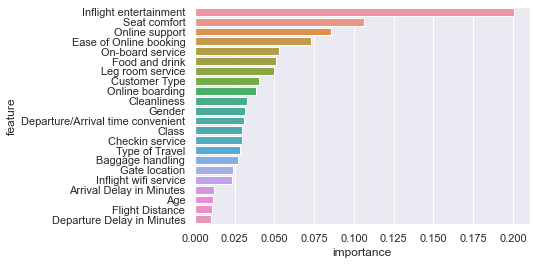

In [424]:
sns.barplot(y = 'feature', x = 'importance', data = _)

`-` Inflight entertainment와 Seat comfort의 중요도 합이 0.3을 넘긴다

In [425]:
scores = cross_validate(rf, dt, target, return_train_score = True, scoring = 'accuracy', cv = skfold)

In [426]:
np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9995, 0.9206666666666667)

### catboost

In [494]:
cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 1000, verbose = 0, max_depth = 6)

In [428]:
scores = cross_validate(cb, dt, target, return_train_score = True, scoring = 'accuracy', cv = skfold)

In [429]:
np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9991666666666668, 0.9363333333333334)

In [532]:
cb.fit(dt, target)

In [533]:
_ = pd.DataFrame(dict(zip(cb.feature_names_, cb.feature_importances_)), index = [0]).T.\
reset_index().rename(columns = {'index':'feature', 0:'importance'}).\
sort_values('importance', ascending = False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

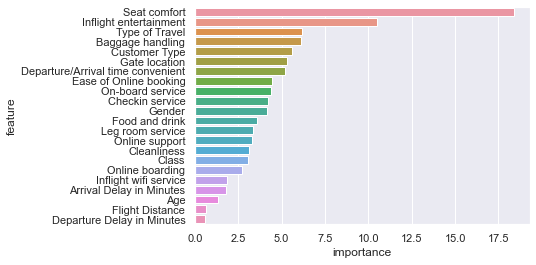

In [534]:
sns.barplot(y = 'feature', x = 'importance', data = _)

`-` 만족도 점수들의 평균 피쳐를 만들겠다

In [535]:
service_features =\
list(set(df.columns.tolist()) -\
{'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'target'})

`-` 서비스 피쳐들의 평균을 새로운 파생변수로 만들자

`-` 위의 중요도를 이용해 가중평균을 구하겠다

In [536]:
dict_ = dict(zip(cb.feature_names_, cb.feature_importances_))

In [537]:
dt['Avg_service'] = 0
test['Avg_service'] = 0
total = sum([dict_[qual] for qual in service_features])

for qual_feature in service_features:
    dt['Avg_service'] = dt['Avg_service'] + dt[qual_feature] * (dict_[qual_feature] / total)
    test['Avg_service'] = test['Avg_service'] + test[qual_feature] * (dict_[qual_feature] / total)

In [540]:
scores = cross_validate(cb, dt, target, return_train_score = True, scoring = 'accuracy', cv = skfold)

In [464]:
np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9990833333333333, 0.9383333333333332)

In [465]:
cb.fit(dt, target)

In [466]:
_ = pd.DataFrame(dict(zip(cb.feature_names_, cb.feature_importances_)), index = [0]).T.\
reset_index().rename(columns = {'index':'feature', 0:'importance'}).\
sort_values('importance', ascending = False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

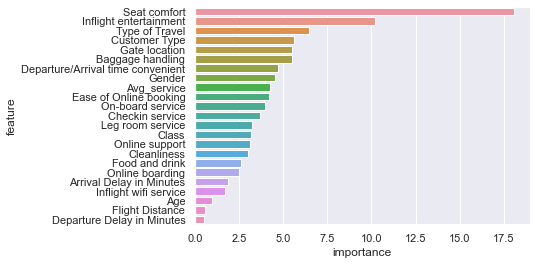

In [467]:
sns.barplot(y = 'feature', x = 'importance', data = _)

### xgboost

In [775]:
xgb = XGBClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 600, max_depth = 7)

In [776]:
scores = cross_validate(xgb, dt, target, return_train_score = True, scoring = 'accuracy', cv = skfold)

[03:53:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:53:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:53:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:53:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [777]:
np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9989166666666666, 0.933)

### lgbm

In [759]:
lgbm = LGBMClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 600, max_depth = 8)

In [760]:
scores = cross_validate(lgbm, dt, target, return_train_score = True, scoring = 'accuracy', cv = skfold)

In [761]:
np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9995, 0.93)

### test 예측

`-` 캣부스트를 사용해 test를 예측하자

In [762]:
skfold = StratifiedKFold(n_splits = 10,  shuffle = True, random_state = 22)

In [763]:
threshold = 0.48 ## 주어진 데이터에서 만족이 55.6% 불만족이 44.4% 이다

In [681]:
cb_valid = []
cb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in skfold.split(dt, target):
    x_train, y_train = dt.iloc[train_idx], target.iloc[train_idx]
    x_valid, y_valid = dt.iloc[valid_idx], target.iloc[valid_idx]
    
    cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 3000, verbose = 0, max_depth = 6)
    cb.fit(x_train, y_train, early_stopping_rounds = 300, verbose = 0)
    
    y_predict = (cb.predict_proba(x_valid)[:,1] > threshold).astype(int) ## 만족일 확률이 0.5 이상이면 1 아니면 0 ## valid셋 예측
    test_predict = cb.predict_proba(test)[:,1]  ## 1(만족)일 확률 ## test셋 예측

    cb_valid.append(accuracy(y_predict, y_valid)) ## valid 예측값
    cb_predict += test_predict / 10 ## test 예측값(10 Fold)

In [591]:
np.mean(cb_valid), np.std(cb_valid) # threshold 0.46
#cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 3000, verbose = 0, max_depth = 6)
#cb.fit(x_train, y_train, early_stopping_rounds = 300, verbose = 0)

(0.9396666666666667, 0.0188826787176914)

In [679]:
np.mean(cb_valid), np.std(cb_valid) # threshold 0.47
#cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 1000, verbose = 0, max_depth = 6)
#cb.fit(x_train, y_train, early_stopping_rounds = 100, verbose = 0)
# 학습 횟수 3000 ---> 1000이 더 낫다

(0.9406666666666668, 0.02037427571991484)

In [682]:
np.mean(cb_valid), np.std(cb_valid) # threshold 0.48
#cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 1000, verbose = 0, max_depth = 6)
#cb.fit(x_train, y_train, early_stopping_rounds = 100, verbose = 0)

(0.9406666666666668, 0.02037427571991484)

In [610]:
np.mean(cb_valid), np.std(cb_valid) # threshold 0.49
#cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 3000, verbose = 0, max_depth = 6)
#cb.fit(x_train, y_train, early_stopping_rounds = 300, verbose = 0)

(0.9393333333333332, 0.020805982045769663)

In [577]:
np.mean(cb_valid), np.std(cb_valid) # threshold 0.5
#cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 3000, verbose = 0, max_depth = 6)
#cb.fit(x_train, y_train, early_stopping_rounds = 300, verbose = 0)

(0.9393333333333335, 0.020428737928059423)

In [578]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/항공사-고객만족도-예측/Data/sample_submission.csv')

In [592]:
pred = (cb_predict > threshold).astype(int) ## 만족일 확률이 threshold보다 높으면 1(만족) 아니면 0(불만족)

In [593]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


In [585]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/항공사-고객만족도-예측/Data/submission1.csv', index = False)

`-` xgb, lgbm, catboost를 앙상블해서

`-` test를 예측해보자

In [762]:
skfold = StratifiedKFold(n_splits = 10,  shuffle = True, random_state = 22)

In [764]:
threshold = 0.48 ## 주어진 데이터에서 만족이 55.6% 불만족이 44.4% 이다

`-` catboost

In [765]:
cb_valid = []
cb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in skfold.split(dt, target):
    x_train, y_train = dt.iloc[train_idx], target.iloc[train_idx]
    x_valid, y_valid = dt.iloc[valid_idx], target.iloc[valid_idx]
    
    cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 1000, verbose = 0, max_depth = 6)
    cb.fit(x_train, y_train, early_stopping_rounds = 100, verbose = 0)
    
    y_predict = (cb.predict_proba(x_valid)[:,1] > threshold).astype(int) ## 만족일 확률이 0.5 이상이면 1 아니면 0 ## valid셋 예측
    test_predict = cb.predict_proba(test)[:,1]  ## 1(만족)일 확률 ## test셋 예측

    cb_valid.append(accuracy(y_predict, y_valid)) ## valid 예측값
    cb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` xgboost

In [767]:
xgb_valid = []
xgb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in skfold.split(dt, target):
    x_train, y_train = dt.iloc[train_idx], target.iloc[train_idx]
    x_valid, y_valid = dt.iloc[valid_idx], target.iloc[valid_idx]
    
    xgb = XGBClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 600, max_depth = 7)
    xgb.fit(x_train, y_train)
    
    y_predict = (xgb.predict_proba(x_valid)[:,1] > threshold).astype(int) ## 만족일 확률이 0.5 이상이면 1 아니면 0 ## valid셋 예측
    test_predict = xgb.predict_proba(test)[:,1]  ## 1(만족)일 확률 ## test셋 예측

    xgb_valid.append(accuracy(y_predict, y_valid)) ## valid 예측값
    xgb_predict += test_predict / 10 ## test 예측값(10 Fold)

[03:51:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:51:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:51:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:51:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [768]:
lgbm_valid = []
lgbm_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in skfold.split(dt, target):
    x_train, y_train = dt.iloc[train_idx], target.iloc[train_idx]
    x_valid, y_valid = dt.iloc[valid_idx], target.iloc[valid_idx]
    
    lgbm = LGBMClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 600, max_depth = 8)
    lgbm.fit(x_train, y_train)
    
    y_predict = (lgbm.predict_proba(x_valid)[:,1] > threshold).astype(int) ## 만족일 확률이 0.5 이상이면 1 아니면 0 ## valid셋 예측
    test_predict = lgbm.predict_proba(test)[:,1]  ## 1(만족)일 확률 ## test셋 예측

    lgbm_valid.append(accuracy(y_predict, y_valid)) ## valid 예측값
    lgbm_predict += test_predict / 10 ## test 예측값(10 Fold)

In [780]:
# cb = CatBoostClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 1000, verbose = 0, max_depth = 6)
# cb.fit(x_train, y_train, early_stopping_rounds = 100, verbose = 0)
# xgb = XGBClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 600, max_depth = 7)
# lgbm = LGBMClassifier(random_state = 22, learning_rate = 0.03, n_estimators = 600, max_depth = 8)

np.mean(cb_valid), np.mean(xgb_valid), np.mean(lgbm_valid)

(0.9406666666666668, 0.9283333333333333, 0.931)

In [781]:
np.std(cb_valid), np.std(xgb_valid), np.std(lgbm_valid)

(0.02037427571991484, 0.021512270400350062, 0.021860669909426127)

In [787]:
pred = ((lgbm_predict + cb_predict + xgb_predict) / 3 > threshold).astype(int) ## 만족일 확률이 threshold보다 높으면 1(만족) 아니면 0(불만족)

In [790]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/항공사-고객만족도-예측/Data/sample_submission.csv')

In [791]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


In [792]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/항공사-고객만족도-예측/Data/submission2.csv', index = False)

`-` catboost만 써보았다

In [800]:
pred = (cb_predict > threshold).astype(int)

## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred ## 점수는 0.937이다

In [801]:
## submission을 csv 파일로 저장
## 점수는 0.937이다
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/항공사-고객만족도-예측/Data/submission3.csv', index = False)

`-` 점수가 잘 나왔다(valid 정확도가 0.94인데 public score가 0.937나옴)

`-` catboost 하이퍼파라미터 바꾸기 전에는 valid 정확도 0.939인데 public score가 0.931 나왔었음

`-` 바꾸기 전은 반복횟수 3000에 조기 중단 300 이었는데 과적합 됐나보다

`-` 반복횟수 1000에 조기 중단 100으로 하니 점수가 위와 같이 잘 나옴(과적합 컨트롤의 중요성)